In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
traindata = pd.read_csv("/kaggle/input/red-vqa-qa-pairs/QA_Pairs_Rad23.csv")
traindata.drop(columns="Unnamed: 0", inplace=True)
traindata.columns = ["image_id", "question", "answer"]
traindata['answer'] = traindata['answer'].str.strip().str.replace('\s+', ' ', regex=True).str.lower()
traindata['question'] = traindata['question'].str.lower()
traindata['address'] = "/kaggle/input/red-vqa-images/Images/" + traindata['image_id'] + ".jpg"
traindata

,image_id,question,answer,address
0,rad_synpic54610,are regions of the brain infarcted?,yes,/kaggle/input/red-vqa-images/Images/rad_synpic...
1,rad_synpic29265,are the lungs normal appearing?,no,/kaggle/input/red-vqa-images/Images/rad_synpic...
2,rad_synpic29265,is there evidence of a pneumothorax,no,/kaggle/input/red-vqa-images/Images/rad_synpic...
3,rad_synpic28602,what type of imaging does this not represent?,ultrasound,/kaggle/input/red-vqa-images/Images/rad_synpic...
4,rad_synpic29265,is this a mri of the chest?,no,/kaggle/input/red-vqa-images/Images/rad_synpic...
...,...,...,...,...
2243,rad_synpic56841,"is this image modality t1, t2, or flair?",flair,/kaggle/input/red-vqa-images/Images/rad_synpic...
2244,rad_synpic26764,is this a pa film?,yes,/kaggle/input/red-vqa-images/Images/rad_synpic...
2245,rad_synpic26764,is this film taken in a pa modality?,yes,/kaggle/input/red-vqa-images/Images/rad_synpic...
2246,rad_synpic31232,what is the hypodensity located inside the ver...,nucleus pulposus,/kaggle/input/red-vqa-images/Images/rad_synpic...


In [3]:
labels = traindata["answer"].value_counts()[traindata["answer"].value_counts() > 5] # Using a threshold of 10 for keeping labels with value counts more than 10
labels.keys()[:10]

Index(['no', 'yes', 'axial', 'right', 'left', 'pa', 'ct', 'brain', 'fat',
       'mri'],
      dtype='object', name='answer')

In [4]:
# Removing rows containing minority classes.

for i in tqdm(range(len(traindata['answer']))):
    if traindata['answer'][i] not in labels.keys():
        traindata = traindata.drop(i)
traindata.reset_index(drop = True, inplace = True)
len(traindata)

100%|██████████| 2248/2248 [00:00<00:00, 4582.70it/s]


1440

In [5]:
from sklearn.model_selection import train_test_split
traindata, testdata = train_test_split(traindata, test_size=0.2, random_state=42)
traindata.reset_index(drop=True)
testdata.reset_index(drop=True)

,image_id,question,answer,address
0,rad_synpic33889,is the liver normal?,no,/kaggle/input/red-vqa-images/Images/rad_synpic...
1,rad_synpic16170,does this patient have pneumomediastinum?,no,/kaggle/input/red-vqa-images/Images/rad_synpic...
2,rad_synpic32108,is there gall bladder pathology?,no,/kaggle/input/red-vqa-images/Images/rad_synpic...
3,rad_synpic42245,are the soft tissue densities in the left hilu...,no,/kaggle/input/red-vqa-images/Images/rad_synpic...
4,rad_synpic35191,what plane is this?,axial,/kaggle/input/red-vqa-images/Images/rad_synpic...
...,...,...,...,...
283,rad_synpic33689,is there evidence of calcification in the panc...,no,/kaggle/input/red-vqa-images/Images/rad_synpic...
284,rad_synpic41050,is there evidence of periappendiceal fluid and...,yes,/kaggle/input/red-vqa-images/Images/rad_synpic...
285,rad_synpic12210,do the lungs appear hyperinflated?,yes,/kaggle/input/red-vqa-images/Images/rad_synpic...
286,rad_synpic39301,is mass effect present?,no,/kaggle/input/red-vqa-images/Images/rad_synpic...


In [6]:
len(traindata["answer"].value_counts()), len(testdata["answer"].value_counts()) 

(25, 22)

In [7]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove stop words
    text = ' '.join([word for word in text.split() if word not in stop_words])
    # Add other preprocessing steps as needed (e.g., punctuation removal, stemming, etc.)
    return text

tqdm.pandas(desc="Preprocessing traindata")
traindata["question"] = traindata["question"].progress_apply(preprocess_text)

# Apply text preprocessing to valdata with tqdm progress bar
tqdm.pandas(desc="Preprocessing valdata")
testdata["question"] = testdata["question"].progress_apply(preprocess_text)

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


Preprocessing valdata: 100%|██████████| 288/288 [00:00<00:00, 214710.19it/s]


In [8]:
train_labels_df = pd.get_dummies(traindata['answer'], dtype = int)
train_labels = np.array(train_labels_df)
train_labels, train_labels.shape

(array([[0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1]]),
 (1152, 25))

In [9]:
decoded_labels = []
for idx in np.argmax(np.array(train_labels), axis = 1):
    decoded_labels.append(train_labels_df.columns[idx])
decoded_labels[:10], traindata['answer'][:10]

(['yes',
  'no',
  'yes',
  'yes',
  'no',
  'right sided pleural effusion',
  'yes',
  'yes',
  'no',
  'flair'],
 1148                             yes
 677                               no
 221                              yes
 113                              yes
 845                               no
 1293    right sided pleural effusion
 174                              yes
 479                              yes
 346                               no
 1436                           flair
 Name: answer, dtype: object)

In [10]:
test_labels_df = pd.DataFrame(np.zeros((len(testdata), 25)), columns = train_labels_df.columns)
for i in range(len(testdata)):
    test_labels_df[testdata['answer'].iloc[i]][i] = 1
test_labels = np.array(test_labels_df)
test_labels, test_labels.shape

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 (288, 25))

In [11]:
decoded_labels = []
for idx in np.argmax(np.array(test_labels), axis = 1):
    decoded_labels.append(test_labels_df.columns[idx])
decoded_labels[:10], testdata['answer'][:10]

(['no', 'no', 'no', 'no', 'axial', 'no', 'yes', 'yes', 'no', 'yes'],
 168        no
 605        no
 548        no
 65         no
 628     axial
 964        no
 1390      yes
 1422      yes
 1199       no
 244       yes
 Name: answer, dtype: object)

In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

docx = np.array(traindata["question"].tolist())
# docx2 = np.array(valdata["question"].tolist())
docx3 = np.array(testdata["question"].tolist())

tokenizer = Tokenizer(oov_token = "<nothing>")
tokenizer.fit_on_texts(docx)

sequences = tokenizer.texts_to_sequences(docx)
sequences = pad_sequences(sequences, padding = "post", maxlen = 35)

# sequences2 = tokenizer.texts_to_sequences(docx2)
# sequences2 = pad_sequences(sequences2, padding = "post", maxlen = 35)

sequences3 = tokenizer.texts_to_sequences(docx3)
sequences3 = pad_sequences(sequences3, padding = "post", maxlen = 35)

2024-04-15 07:07:44.643941: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 07:07:44.644127: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 07:07:44.768926: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [14]:
def augment_data(tup, label):
    image, sequence = tup
    # Randomly rotate the image (within a range of -20 to 20 degrees)
    angle = tf.random.uniform([], minval=-20, maxval=20, dtype=tf.float32)
    image = tf.image.rot90(image, tf.cast(angle / 90, dtype=tf.int32))
    
    # Randomly shift the width and height
    shift_x = tf.random.uniform(shape=[], minval=-30, maxval=30, dtype=tf.int32)
    shift_y = tf.random.uniform(shape=[], minval=-30, maxval=30, dtype=tf.int32)
    image = tf.roll(image, shift_x, axis=1)
    image = tf.roll(image, shift_y, axis=0)

    return (image, sequence), label

def process_data(image_path, text_sequence, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (256, 256))
    image = tf.cast(image/255, dtype = tf.float32)
    return (image, text_sequence), label

BATCH_SIZE = 16
BUFFER_SIZE = 100

train_data = tf.data.Dataset.from_tensor_slices((traindata['address'], sequences, train_labels))
# val_data = tf.data.Dataset.from_tensor_slices((valdata['address'], sequences2, val_labels))
test_data = tf.data.Dataset.from_tensor_slices((testdata['address'], sequences3, test_labels))

train_data = train_data.map(process_data)
# augmented_data = train_data.map(augment_data)
# train_data  = train_data.concatenate(augmented_data)

train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.shuffle(buffer_size=BUFFER_SIZE)
train_data = train_data.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# val_data = val_data.map(process_data)
# val_data = val_data.batch(BATCH_SIZE)
# val_data = val_data.shuffle(buffer_size=BUFFER_SIZE)
# val_data = val_data.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_data = test_data.map(process_data)
test_data = test_data.batch(BATCH_SIZE)
test_data = test_data.shuffle(buffer_size=BUFFER_SIZE)
test_data = test_data.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

train_data, test_data

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 35), dtype=tf.int32, name=None)), TensorSpec(shape=(None, 25), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 35), dtype=tf.int32, name=None)), TensorSpec(shape=(None, 25), dtype=tf.float64, name=None))>)

In [15]:
import os
import keras
from keras import layers

from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten,
    LSTM, Embedding, Dense, Concatenate,
    Bidirectional, Dropout, BatchNormalization
    )

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.metrics import f1_score

In [20]:
image_inputs = keras.Input(shape=(256, 256, 3))

image_branch = Conv2D(64, (3, 3), activation='relu', padding="same")(image_inputs)
image_branch = MaxPooling2D((2, 2))(image_branch)
image_branch = Dropout(0.2)(image_branch)
image_branch = Conv2D(32, (3, 3), activation='relu', padding="same")(image_branch)
image_branch = MaxPooling2D((2, 2))(image_branch)
image_branch = Dropout(0.1)(image_branch)
image_branch = Conv2D(32, (3, 3), activation='relu', padding="same")(image_branch)
image_branch = MaxPooling2D((2, 2))(image_branch)
image_branch = Dropout(0.1)(image_branch)
image_branch = Conv2D(32, (3, 3), activation='relu')(image_branch)
image_branch = MaxPooling2D((2, 2))(image_branch)
image_branch = Dropout(0.2)(image_branch)
representation = Flatten()(image_branch)

vocab_size = sequences.max() + 1
text_inputs = layers.Input((35,), dtype="int64")
text_branch = Embedding(input_dim=vocab_size, output_dim=64)(text_inputs)
text_branch = Bidirectional(LSTM(64, return_sequences=False))(text_branch)
pooled_output = Dropout(0.2)(text_branch)

combined = Concatenate()([representation, pooled_output])
combined = Dropout(0.2)(combined)
combined = Dense(512, activation="relu")(combined)
combined = Dense(256, activation="relu")(combined)

output = Dense(len(labels), activation='softmax')(combined)
model = keras.Model(inputs=[image_inputs, text_inputs], outputs=output, name = "CNN_LSTM_ENCODER")
model.compile(optimizer=keras.optimizers.Adam(), 
              loss=keras.losses.CategoricalCrossentropy(from_logits=True), 
              metrics=["accuracy"])
model.summary()

Model: "CNN_LSTM_ENCODER"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 256, 256,  │      1,792 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128, 128,  │          0 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │     18,464 │ dropout_6[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_5[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │      9,248 │ dropout_7[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_6[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 30, 30,    │      9,248 │ dropout_8[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 15, 15,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 35, 64)    │     48,768 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 15, 15,    │          0 │ max_pooling2d_7[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128)       │     66,048 │ embedding_1[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 7200)      │          0 │ dropout_9[0][0] 

 Total params: 4,043,769 (15.43 MB)

 Trainable params: 4,043,769 (15.43 MB)

 Non-trainable params: 0 (0.00 B)

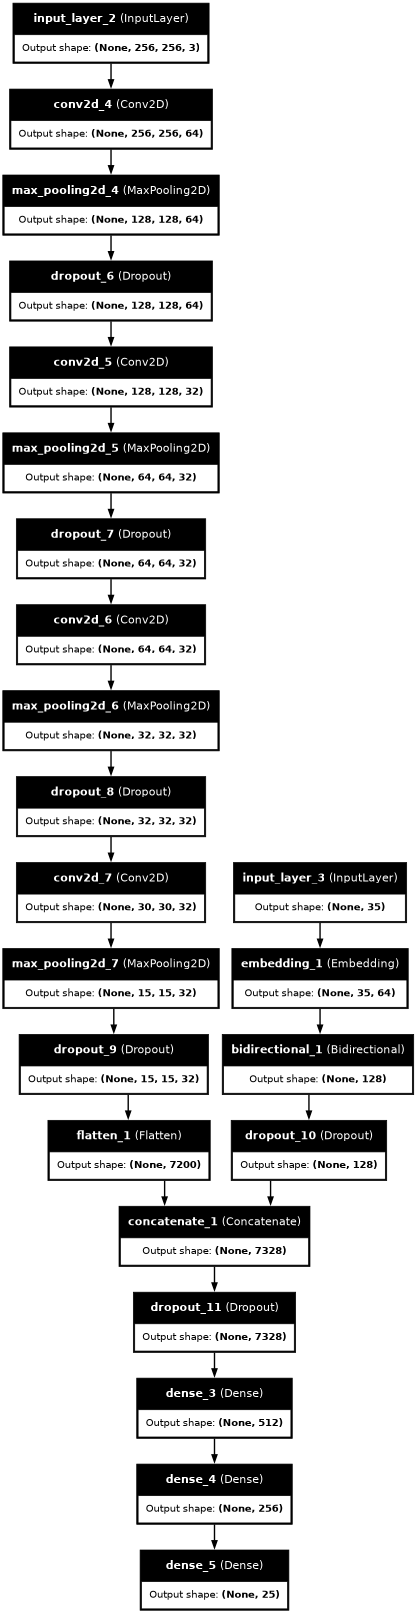

In [21]:
tf.keras.utils.plot_model(model, to_file='model_visualization.png', show_shapes=True, show_layer_names=True, dpi = 50, rankdir='LB')

In [32]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('cnn-lstm.keras',
                                                  verbose=1, save_best_only = True,
                                                monitor='val_accuracy')

history = model.fit(
    train_data,
    epochs=20,
    validation_data = test_data,
    callbacks = checkpointer
         )

Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8673 - loss: 0.3359
Epoch 1: val_accuracy improved from -inf to 0.62500, saving model to cnn-lstm.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.8673 - loss: 0.3358 - val_accuracy: 0.6250 - val_loss: 1.5885
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9162 - loss: 0.2760
Epoch 2: val_accuracy did not improve from 0.62500
72/72 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9162 - loss: 0.2760 - val_accuracy: 0.6181 - val_loss: 1.5607
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9366 - loss: 0.1784
Epoch 3: val_accuracy did not improve from 0.62500
72/72 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9365 - loss: 0.1789 - val_accuracy: 0.6250 - val_loss: 1.6241
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9422 - loss: 0.1854
Epoch 4: val_accuracy did not improve from 0.62500
72/72 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9422 - loss: 0.1856 - val_acc

In [36]:
from tensorflow.keras.callbacks import CSVLogger
# Define a CSV logger to save training logs
csv_logger = CSVLogger('training.log')
csv_logger.to_csv('/kaggle/working/training_logs.csv', index=False)

AttributeError: 'CSVLogger' object has no attribute 'to_csv'

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


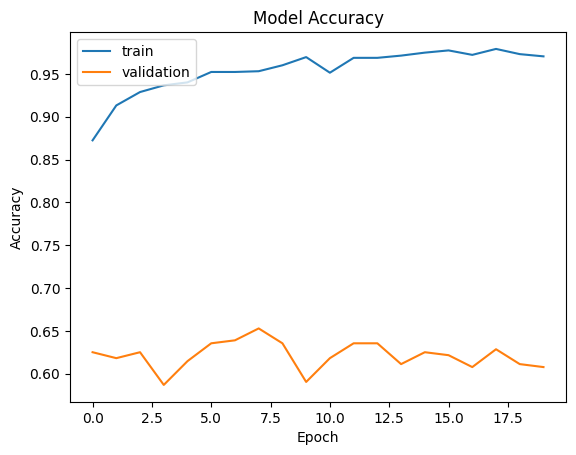

In [37]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [26]:
decoded_labels = []
for i in tqdm(range(len(testdata))):
    image_path = testdata['address'].iloc[i]
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (256, 256))
    image = tf.cast(image/255, dtype = tf.float32)
    text = testdata['question'].iloc[i]
    seq = tokenizer.texts_to_sequences([text])
    seq = pad_sequences(seq, padding = "post", maxlen = 35)
    yp = model.predict((np.expand_dims(image, axis = 0), seq), verbose = 0)
    yp = np.argmax(yp[0])
    decoded_labels.append(test_labels_df.columns[yp])
testdata["prediction"] = decoded_labels
testdata

100%|██████████| 288/288 [00:31<00:00,  9.09it/s]


,image_id,question,answer,address,prediction
168,rad_synpic33889,liver normal?,no,/kaggle/input/red-vqa-images/Images/rad_synpic...,no
605,rad_synpic16170,patient pneumomediastinum?,no,/kaggle/input/red-vqa-images/Images/rad_synpic...,no
548,rad_synpic32108,gall bladder pathology?,no,/kaggle/input/red-vqa-images/Images/rad_synpic...,no
65,rad_synpic42245,soft tissue densities left hilum equivalent si...,no,/kaggle/input/red-vqa-images/Images/rad_synpic...,no
628,rad_synpic35191,plane this?,axial,/kaggle/input/red-vqa-images/Images/rad_synpic...,brain
...,...,...,...,...,...
1367,rad_synpic33689,evidence calcification pancreas?,no,/kaggle/input/red-vqa-images/Images/rad_synpic...,no
265,rad_synpic41050,evidence periappendiceal fluid fat stranding?,yes,/kaggle/input/red-vqa-images/Images/rad_synpic...,no
1425,rad_synpic12210,lungs appear hyperinflated?,yes,/kaggle/input/red-vqa-images/Images/rad_synpic...,no
493,rad_synpic39301,mass effect present?,no,/kaggle/input/red-vqa-images/Images/rad_synpic...,yes


In [28]:
testdata.to_csv('/kaggle/working/prediction.csv', index=False)

In [29]:
from sklearn.metrics import classification_report

rep = pd.DataFrame(classification_report(testdata['answer'], testdata['prediction'], output_dict = True))
rep

,"5.6cm focal, predominantly hypodense",axial,bilateral,brain,ct,diffuse,fat,female,flair,lateral ventricles,...,right,right lung,right side,right upper lobe,with contrast,x-ray,yes,accuracy,macro avg,weighted avg
precision,1.0,0.100000,0.0,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,...,0.250000,0.0,0.0,0.0,0.0,0.0,0.765957,0.600694,0.218443,0.621347
recall,1.0,0.200000,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,...,0.333333,0.0,0.0,0.0,0.0,0.0,0.576000,0.600694,0.224159,0.600694
f1-score,1.0,0.133333,0.0,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,...,0.285714,0.0,0.0,0.0,0.0,0.0,0.657534,0.600694,0.212545,0.600830
support,2.0,5.000000,2.0,1.0,2.0,2.0,1.000000,1.0,1.0,2.0,...,3.000000,0.0,2.0,1.0,0.0,2.0,125.000000,0.600694,288.000000,288.000000


In [30]:
rep[rep.T['support'].sort_values(ascending = False)[2:15].keys()]

,yes,no,axial,pa,left,right,bilateral,x-ray,right side,pancreas,diffuse,ct,mri
precision,0.765957,0.626667,0.100000,0.0,0.0,0.250000,0.0,0.0,0.0,1.000000,0.0,0.0,0.0
recall,0.576000,0.770492,0.200000,0.0,0.0,0.333333,0.0,0.0,0.0,0.500000,0.0,0.0,0.0
f1-score,0.657534,0.691176,0.133333,0.0,0.0,0.285714,0.0,0.0,0.0,0.666667,0.0,0.0,0.0
support,125.000000,122.000000,5.000000,4.0,4.0,3.000000,2.0,2.0,2.0,2.000000,2.0,2.0,2.0


In [31]:
rep.T['f1-score'].sort_values(ascending = False)[:20]

5.6cm focal, predominantly hypodense    1.000000
left kidney                             1.000000
no                                      0.691176
pancreas                                0.666667
fat                                     0.666667
yes                                     0.657534
weighted avg                            0.600830
accuracy                                0.600694
right                                   0.285714
macro avg                               0.212545
axial                                   0.133333
x-ray                                   0.000000
with contrast                           0.000000
right upper lobe                        0.000000
right side                              0.000000
right lung                              0.000000
brain                                   0.000000
ct                                      0.000000
one                                     0.000000
mri                                     0.000000
Name: f1-score, dtyp